# Place Cell Analyses

Analyze TH data for place cells.

Cells of interest:
- No cells show clear / traditional place cell responses

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import (compute_occupancy, compute_spatial_bin_edges,
                                          compute_spatial_bin_assignment)
from spiketools.spatial.utils import get_pos_ranges, get_bin_width
from spiketools.spatial.information import compute_spatial_information_2d

from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue

from spiketools.plts.space import plot_positions, plot_heatmap
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes

from spiketools.utils import restrict_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions, compute_bin_firing

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [6]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [7]:
# Set which example unit to extract
uind = 49

In [8]:
# Define bins to use
bins = [7, 21]

In [9]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 100

## Load Data

In [10]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [11]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [12]:
# Extract the position data
pos = nwbfile.acquisition['position']['xy_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [13]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [14]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

In [15]:
# Drop spikes until task time
st = nwbfile.trials['start_time'][0]
en = nwbfile.trials['stop_time'][-1]
spikes = restrict_range(spikes, st, en)

## Position Data

In [16]:
# Compute position ranges
x_range, y_range = get_pos_ranges(positions)

In [17]:
# Check ranges of positon
print('Position X-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*x_range, x_range[1] - x_range[0]))
print('Position Y-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*y_range, y_range[1] - y_range[0]))

Position X-range:  365.40 - 404.59 (39.18)
Position Y-range:  285.00 - 433.00 (148.00)


In [18]:
# Get position values for each spike
spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
spike_positions = np.array([spike_xs, spike_ys])

In [19]:
# Check binning
x_bin_edges, y_bin_edges = compute_spatial_bin_edges(positions, bins)

In [20]:
# Check bin sizes
print('Bin widths: {:1.2f}, {:1.2f}'.format(get_bin_width(x_bin_edges), get_bin_width(y_bin_edges)))

Bin widths: 5.60, 7.05


### Occupancy

In [21]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins, speed, set_nan=True)

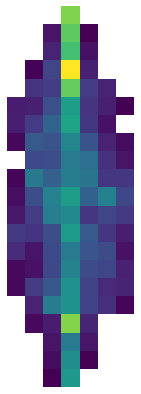

In [22]:
# Plot occupancy
plot_heatmap(occ, transpose=True, ignore_zero=False, figsize=(5, 7))

## Check spike locations

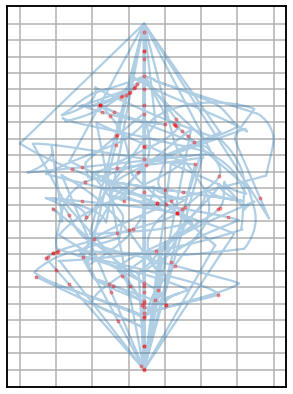

In [23]:
# Plot the map across all position traces
plot_positions(positions, spike_positions,
               x_bins=x_bin_edges, y_bins=y_bin_edges,
               figsize=(5, 7))

## Compute Binned Spatial Firing

In [24]:
# Compute spatial bin assignments for each spike
x_binl, y_binl = compute_spatial_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)

In [25]:
# Compute summary map of bin firing
bin_firing = compute_bin_firing(x_binl, y_binl, bins)

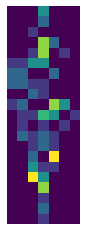

In [26]:
# Check the firing map
plot_heatmap(bin_firing, transpose=True)

In [27]:
# Normalize bin firing by occupancy
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
normed_bin_firing = bin_firing / occ

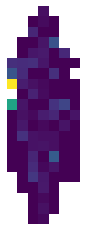

In [28]:
# Plot occupancy-normalized spatial firing
plot_heatmap(normed_bin_firing, transpose=True)

## Compute Spatial Information

In [29]:
# Compute the spatial information
spike_info = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)
print(spike_info)

0.9629485861057206


In [30]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

In [31]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):    
    
    spike_xs, spike_ys = get_spike_positions(stimes, ptimes, positions)
    surrs[ind] = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)

In [32]:
# Compute the empirical p-value based on surrogates
surr_p_val = compute_empirical_pvalue(spike_info, surrs)

# Compute z-score of spatial information compared to surrogates
z_score = zscore_to_surrogates(spike_info, surrs)

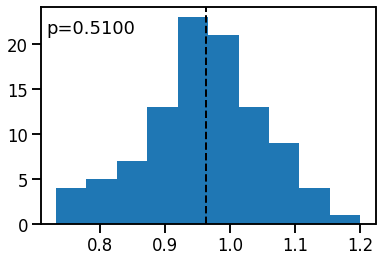

In [33]:
# Plot distribution of surrogates with measured empirical value
plot_surrogates(surrs, spike_info, surr_p_val)

## All Cells

In [34]:
# # Examine spatial firing across all cells
# for ii, ax in zip(keep_inds, make_axes(n_keep)):
    
#     spikes = nwbfile.units.get_unit_spike_times(ii)
#     spikes = restrict_range(spikes, st, en)
    
#     spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
    
#     plot_positions(positions, np.array([spike_xs, spike_ys]), ax=ax)
#     ax.set_title(ii)

In [35]:
# # Examine spatial firing across all cells
# for ii, ax in zip(keep_inds, make_axes(n_keep)):
    
#     spikes = nwbfile.units.get_unit_spike_times(ii)
#     spikes = restrict_range(spikes, st, en)
    
#     spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
#     spike_positions = np.array([spike_xs, spike_ys])
    
#     # Compute spatial bin assignments for each spike, and compute normalized bin firing
#     x_binl, y_binl = compute_spatial_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)
#     bin_firing = compute_bin_firing(x_binl, y_binl, bins)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         normed_bin_firing = bin_firing / occ
    
#     # Compute spatial information
#     spike_info = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)
    
#     # Create shuffled time series for comparison
#     times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)
    
#     # Compute spatial information measures on surrogates
#     surrs = np.zeros(n_surrogates)
#     for ind, stimes in enumerate(times_shuffle):    
#         spike_xs, spike_ys = get_spike_positions(stimes, ptimes, positions)
#         surrs[ind] = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)
        
#     # Compute z-score & p-value based on surrogates
#     z_score = zscore_to_surrogates(spike_info, surrs)
#     surr_p_val = compute_empirical_pvalue(spike_info, surrs)

#     # Plot occupancy-normalized spatial firing
#     plot_heatmap(normed_bin_firing, transpose=True, ax=ax)
    
#     color = 'red' if surr_p_val < 0.05 else 'black'
#     title = 'U{} - ({:1.2f}-{:1.2f}) \n z-{:1.2f}, p-{:1.2f}'.format(\
#         ii, np.nanmin(normed_bin_firing), np.nanmax(normed_bin_firing), z_score, surr_p_val)
#     ax.set_title(title, fontdict={'fontsize' : 12})